# Deep learning for Recommendation

The goal of this notebook is build a recommender system for movies using deep learning on MovieLens 1M dataset.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os

from IPython.display import Image
Image(url="https://dncache-mauganscorp.netdna-ssl.com/thumbseg/1998/1998762-bigthumbnail.jpg")

### Load dataset

The MovieLens 1M dataset contains 1,000,209 ratings for 3,952 movies by 6,040 users who joined MovieLens in 2000.
More information about the dataset: http://files.grouplens.org/datasets/movielens/ml-1m-README.txt

In [3]:
dataset_folder="/home/ubuntu/datasets/reco/ml-1m"

In [4]:
all_ratings = pd.read_csv(os.path.join(dataset_folder, 'ratings.dat'), sep='::', engine='python',
                          names=['userId', 'movieId', 'rating', 'timestamp'])
all_ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
items = pd.read_csv(os.path.join(dataset_folder, 'movies.dat'), sep='::', encoding='latin-1', engine='python',
                    names=['movieId', 'title', 'genres'])
items.head()

,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
all_ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [7]:
max_user_id = all_ratings['userId'].max()
max_user_id

6040

In [8]:
max_item_id = all_ratings['movieId'].max()
max_item_id

3952

### Train-validation-test split

In [9]:
from sklearn.model_selection import train_test_split

ratings_tmp, ratings_test = train_test_split(all_ratings, test_size=0.2, random_state=0)

ratings_train, ratings_validation = train_test_split(ratings_tmp, test_size=0.2, random_state=0)

print('Training set,', ratings_train.shape)
print('Validation set,', ratings_validation.shape)
print('Test set,', ratings_test.shape)

user_id_train = ratings_train['userId']
item_id_train = ratings_train['movieId']
rating_train = ratings_train['rating']

user_id_valid = ratings_validation['userId']
item_id_valid = ratings_validation['movieId']
rating_valid = ratings_validation['rating']

user_id_test = ratings_test['userId']
item_id_test = ratings_test['movieId']
rating_test = ratings_test['rating']

('Training set,', (640133, 4))
('Validation set,', (160034, 4))
('Test set,', (200042, 4))


## Simple matrix factorization

Mathematically, the prediction of rating is given by $y_{ij} = u_i^T v_j$, where $u_i$ is user $i$ embedding vector, $v_j$ is item $j$ embedding vector.

In [10]:
from keras.layers import Input, Embedding, Flatten, merge, Dense, Dropout, Lambda
from keras.regularizers import l2
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [103]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

y = merge([user_vecs, item_vecs], mode='dot', output_shape=(1,))

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

### Error at random initialization

In [104]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

initial_test_preds = model.predict([user_id_test, item_id_test])
print("Random init MSE: %0.3f" % mean_squared_error(initial_test_preds, rating_test))
print("Random init MAE: %0.3f" % mean_absolute_error(initial_test_preds, rating_test))

Random init MSE: 14.040
Random init MAE: 3.577


### Training

In [105]:
def get_batch(x, y, valid=False, batch_size=64):
    """ batch generator to enable sparse input """
    index = np.arange(x[0].size)
    start = 0
    while True:
        if start == 0 and valid is False:
            np.random.shuffle(index)
        batch = index[start:start+batch_size]
        
        yield [x[0].iloc[batch], x[1].iloc[batch]], y.iloc[batch]
        
        start += batch_size
        if start >= x[0].size:
            start = 0

In [106]:
history = model.fit_generator(get_batch([user_id_train, item_id_train], rating_train, valid=False, batch_size=64), 
                              samples_per_epoch=6400, nb_epoch=100,
                              validation_data=get_batch([user_id_valid, item_id_valid], rating_valid, valid=True, batch_size=64), 
                              nb_val_samples=30,
                              verbose=2)

Epoch 1/100
6400/6400 [==============================] - 0s - loss: 3.5830 - val_loss: 3.6883
Epoch 2/100
6400/6400 [==============================] - 0s - loss: 3.5653 - val_loss: 3.6872

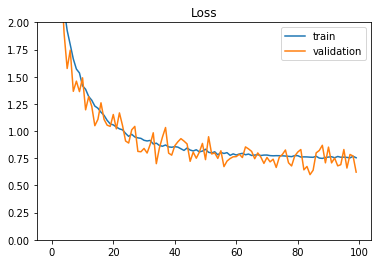

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [24]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.942
Final test MAE: 0.756


---
Task 1: Turn simple matrix factorization into deep network
-------

Turn the simple matrix factorization into a 1-hidden layer neural network with ReLU and 64 hidden nodes. This model should improve your validation / test error. 

Mathematically, transform  $y_{ij} = u_i^T v_j$ into $y_{ij} = W^{(2)}(ReLU(W^{(1)}[u_i;v_j]+b^{(1)})+b^{(2)}$.

To code this,
* Concatenation of user and item vectors can be done using "concat" mode of `merge` function
* Use function `Dense` to create a densely connected layer $activation(Wx + b)$

---

In [80]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')

hidden_layer = Dense(64, activation='relu')(input_vecs)

y = Dense(1)(hidden_layer)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [81]:
history = model.fit_generator(get_batch([user_id_train, item_id_train], rating_train, valid=False, batch_size=64), 
                              samples_per_epoch=6400, nb_epoch=100,
                              validation_data=get_batch([user_id_valid, item_id_valid], rating_valid, valid=True, batch_size=64), 
                              nb_val_samples=30,
                              verbose=2)

Epoch 1/100
6400/6400 [==============================] - 1s - loss: 3.0488 - val_loss: 2.0144
Epoch 2/100
6400/6400 [==============================] - 0s - loss: 1.1130 - val_loss: 0.9627

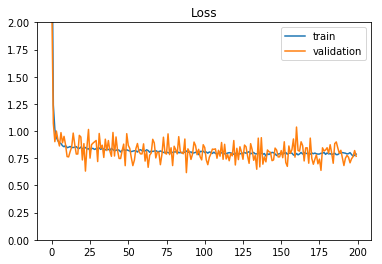

In [69]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [70]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.901
Final test MAE: 0.737


---
Task 2
---------
Introduce Dropout on the hidden layer of the neural network. 
Keras provides `Dropout` function, start with keep probability 0.5.

Keep in mind that with dropout, your network is training only a part of its weights at each step, so you should increase number of epochs to have fair comparison with previous runs. For example, double number of epochs if your keep probability is 0.5.

The right amount of dropout should improve your validation / test error.

Mathematically, make $y_{ij} = W^{(2)}(Dropout(ReLU(W^{(1)}[u_i;v_j]+b^{(1)}), 0.5)+b^{(2)}$.
                                       
---

In [75]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 30
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs], mode='concat')

h1 = Dense(64, activation='relu')(input_vecs)

h1_dropout = Dropout(0.5)(h1)

y = Dense(1)(h1)

model = Model(input=[user_id_input, item_id_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [76]:
history = model.fit_generator(get_batch([user_id_train, item_id_train], rating_train, valid=False, batch_size=64), 
                              samples_per_epoch=6400, nb_epoch=200,
                              validation_data=get_batch([user_id_valid, item_id_valid], rating_valid, valid=True, batch_size=64), 
                              nb_val_samples=30,
                              verbose=2)

Epoch 1/200
6400/6400 [==============================] - 1s - loss: 3.1184 - val_loss: 2.2416

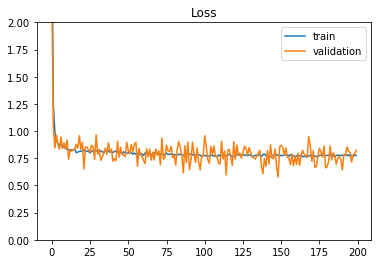

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [78]:
test_preds = model.predict([user_id_test, item_id_test])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.872
Final test MAE: 0.728


---
Task 4
---------

Try to get the best performance you can using a multi-layer model! State-of-the-art methods achieve MAE of [0.68](http://www.mymedialite.net/examples/datasets.html) on MovieLens-1M.

One avenue you can explore is to add multiple layers.

Another one is to try another loss function like MSE.

---

## Adding item genres into the deep network

Meta information about movies might help prediction, for example, in the case of cold-start when few ratings are available about item.

### Convert genres of items from text into vector representation

In [63]:
genre_to_id = { "Action":0, "Adventure":1, "Animation":2, "Children's":3, "Comedy":4, "Crime":5, "Documentary":6, "Drama":7, 
               "Fantasy":8, "Film-Noir":9, "Horror":10, "Musical":11, "Mystery": 12, "Romance":13, "Sci-Fi":14, "Thriller":15, 
               "War":16, "Western":17}    
genre_ids = []
for genre in items['genres']:
    genre_vector = (np.arange(18)==19).astype(np.float32)
    for genre_str in genre.split('|'):
        genre_vector += (np.arange(18) == genre_to_id[genre_str]).astype(np.float32)
    genre_ids.append(genre_vector)
    
items['genre_ids'] = pd.Series(genre_ids, index=items.index)
items.head()

,movieId,title,genres,genre_ids
0,1,Toy Story (1995),Animation|Children's|Comedy,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
4,5,Father of the Bride Part II (1995),Comedy,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


---
Task 5
---------

Modify the network definition below to include `meta_input` vector that represents a vector of item genres.

Train the network with the procedure below.

---

In [54]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
meta_input = Input(shape=[18,], name='meta_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, meta_input], mode='concat')

h1 = Dense(64, activation='relu')(input_vecs)
h1_dropout = Dropout(0.5)(h1)
y = Dense(1)(h1_dropout)

model = Model(input=[user_id_input, item_id_input, meta_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [64]:
def get_join_batch(x, y, z, valid=False, batch_size=64):
    """ batch generator to enable sparse input """
    index = np.arange(x[0].size)
    start = 0
    while True:
        if start == 0 and valid is False:
            np.random.shuffle(index)
        batch = index[start:start+batch_size]
        merge_x_z = pd.merge(x[1].iloc[batch].to_frame(), z, on='movieId')
        yield [x[0].iloc[batch], x[1].iloc[batch], np.matrix(merge_x_z['genre_ids'].tolist())], y.iloc[batch]
        start += batch_size
        if start >= x[0].size:
            start = 0

In [66]:
iter=get_join_batch([user_id_train, item_id_train], rating_train, items[['movieId', 'genre_ids']], 
                                        valid=False, batch_size=1)
iter.next()

([409900    2458
  Name: userId, dtype: int64, 409900    589
  Name: movieId, dtype: int64, matrix([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
            0.,  1.,  1.,  0.,  0.]], dtype=float32)],
 409900    5
 Name: rating, dtype: int64)

In [56]:
history = model.fit_generator(get_join_batch([user_id_train, item_id_train], rating_train, items[['movieId', 'genre_ids']], 
                                        valid=False, batch_size=64), 
                              samples_per_epoch=6400, nb_epoch=200,
                              validation_data=get_join_batch([user_id_valid, item_id_valid], rating_valid, items[['movieId', 'genre_ids']], 
                                                        valid=True, batch_size=64), 
                              nb_val_samples=30,
                              verbose=2)

Epoch 1/200
6400/6400 [==============================] - 1s - loss: 2.4434 - val_loss: 1.1675

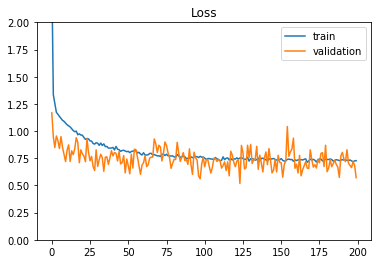

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [58]:
merge_x_z = pd.merge(item_id_test.to_frame(), items[['movieId', 'genre_ids']], on='movieId')
test_preds = model.predict([user_id_test, item_id_test, np.matrix(merge_x_z['genre_ids'].tolist())])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.876
Final test MAE: 0.709


## Adding image features using pre-trained VGG16

This example uses VGG16, a model trained on the ImageNet dataset - which contains millions of images classified in 1000 categories. 

In [15]:
Image(url='https://blog.keras.io/img/imgclf/vgg16_original.png')

Example of movie poster.

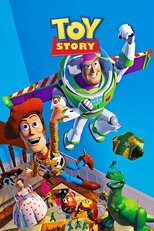

In [13]:
images_folder = '/home/ubuntu/datasets/reco/images_movie_1m/all'
Image(filename=images_folder + '/1.jpg') 

In [17]:
movieIds = dict()
for dirpath, dirnames, filenames in os.walk(images_folder):
    for f in filenames:
        movieIds[int(f.split('.')[0])] = 1

Load pre-computed features: VGG16 output on movie posters

In [19]:
size = 1000
image_features = np.load(open('/home/ubuntu/datasets/reco/images_movie_1m_features.npy', 'rb')).reshape((3800, size))
image_features_df = pd.concat([pd.Series(movieIds.keys(), dtype=np.int32), pd.Series(image_features.tolist())], axis=1, keys=['movieId', 'image_features'])
for i in range(max_item_id+1):
    if i not in movieIds:
        df_tmp = pd.concat([pd.Series([i], dtype=np.int32), pd.Series([np.zeros((size,), dtype=np.float32)])], axis=1, keys=['movieId', 'image_features'])
        image_features_df = pd.concat([image_features_df, df_tmp], ignore_index=True)
image_features_df.head() 

,movieId,image_features
0,1,"[0.000155083733262, 0.00274936645292, 0.000468..."
1,2,"[0.000133678142447, 0.00213223742321, 0.000418..."
2,3,"[0.000117121613584, 0.00173930008896, 0.000255..."
3,4,"[6.39869758743e-05, 0.00087278848514, 0.000110..."
4,5,"[0.000298001861665, 0.00372964353301, 0.000714..."


In [28]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')
image_input = Input(shape=[size,], name='image_item')

embedding_size = 32
user_embedding = Embedding(output_dim=embedding_size, input_dim=max_user_id + 1,
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=max_item_id + 1,
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)

input_vecs = merge([user_vecs, item_vecs, image_input], mode='concat')

h1 = Dense(64, activation='relu')(input_vecs)
h1_dropout = Dropout(0.5)(h1)
h2 = Dense(32, activation='relu')(h1_dropout)
h2_dropout = Dropout(0.5)(h2)
y = Dense(1)(h2_dropout)

model = Model(input=[user_id_input, item_id_input, image_input], output=y)
model.compile(optimizer='adam', loss='mae')

In [21]:
def get_join_batch(x, y, z, valid=False, batch_size=64):
    """ batch generator to enable sparse input """
    index = np.arange(x[0].size)
    start = 0
    while True:
        if start == 0 and valid is False:
            np.random.shuffle(index)
        batch = index[start:start+batch_size]
        merge_x_z = pd.merge(x[1].iloc[batch].to_frame(), z, on='movieId')
        yield [x[0].iloc[batch], x[1].iloc[batch], np.array(merge_x_z['image_features'].tolist(), dtype=np.float32)], y.iloc[batch]
        start += batch_size
        if start >= x[0].size:
            start = 0

In [30]:
history = model.fit_generator(get_join_batch([user_id_train, item_id_train], rating_train, image_features_df, 
                                        valid=False, batch_size=64), 
                              samples_per_epoch=6400, nb_epoch=200,
                              validation_data=get_join_batch([user_id_valid, item_id_valid], rating_valid, image_features_df, 
                                                        valid=True, batch_size=64), 
                              nb_val_samples=30,
                              verbose=2)

Epoch 1/200
0s - loss: 0.7046 - val_loss: 0.8007
Epoch 2/200
0s - loss: 0.7010 - val_loss: 0.6480
Epoch 3/200
0s - loss: 0.7114 - val_loss: 0.7334
Epoch 4/200
0s - loss: 0.7067 - val_loss: 0.6861
Epoch 5/200
0s - loss: 0.7015 - val_loss: 0.7916
Epoch 6/200
0s - loss: 0.7114 - val_loss: 0.7786
Epoch 7/200
0s - loss: 0.7041 - val_loss: 0.7615
Epoch 8/200
0s - loss: 0.7106 - val_loss: 0.7239
Epoch 9/200
0s - loss: 0.7266 - val_loss: 0.7174
Epoch 10/200
0s - loss: 0.7268 - val_loss: 0.7097
Epoch 11/200
0s - loss: 0.7013 - val_loss: 0.7207
Epoch 12/200
0s - loss: 0.7164 - val_loss: 0.6680
Epoch 13/200
0s - loss: 0.7158 - val_loss: 0.6313
Epoch 14/200
0s - loss: 0.7086 - val_loss: 0.8014
Epoch 15/200
0s - loss: 0.7189 - val_loss: 0.7429
Epoch 16/200
0s - loss: 0.7185 - val_loss: 0.7496
Epoch 17/200
0s - loss: 0.7265 - val_loss: 0.6432
Epoch 18/200
0s - loss: 0.7174 - val_loss: 0.6836
Epoch 19/200
0s - loss: 0.7185 - val_loss: 0.7914
Epoch 20/200
0s - loss: 0.7148 - val_loss: 0.7518
Epoch 21/

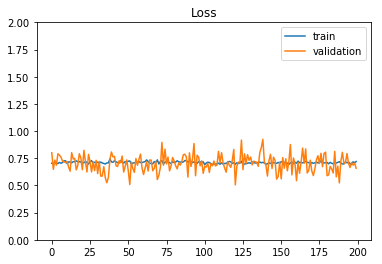

In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0, 2)
plt.legend(loc='best')
plt.title('Loss');

In [32]:
merge_x_z = pd.merge(item_id_test.to_frame(), image_features_df, on='movieId')
test_preds = model.predict([user_id_test, item_id_test, np.matrix(merge_x_z['image_features'].tolist())])
print("Final test MSE: %0.3f" % mean_squared_error(test_preds, rating_test))
print("Final test MAE: %0.3f" % mean_absolute_error(test_preds, rating_test))

Final test MSE: 0.881
Final test MAE: 0.695
